In [12]:
import pandas as ps
import rasterio
import fiona
import shapefile
import os, sys, csv, re
import shapely.geometry
import statsmodels.api as sm

from rasterio.transform import from_bounds
from rasterio.plot import show
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn import svm

from scipy.stats import zscore
from scipy.interpolate import make_interp_spline, BSpline

In [66]:
# base_dir = r"D:\Acadamics\University\Year_3\Sem_2\GIS3005 - Remote Sensing\Assignment\1"
base_dir = os.getcwd()
nightlight = os.path.join(base_dir, "output", "nightlight.csv")
gdp_dataset_filtered = os.path.join(base_dir, "output", "API_NY.GDP.MKTP.CD_DS2_en_csv_v2_4770391_filtered.csv")
countries_interested = ["Pakistan", "Nepal", "Sri Lanka", "India", "Bhutan", "Bangladesh"]

In [3]:
def predict(train_x, train_y, test_x, test_y):

    # # Normalize the input data
    # train_x = (train_x.reshape(-1, 1)[:,1:] - np.mean(train_x.reshape(-1, 1)[:,1:], axis=0)) / np.std(train_x.reshape(-1, 1)[:,1:], axis=0)
    # test_x = (test_x.reshape(-1, 1)[:,1:] - np.mean(test_x.reshape(-1, 1)[:,1:], axis=0)) / np.std(test_x.reshape(-1, 1)[:,1:], axis=0)

    # model = tf.keras.Sequential()
    # model.compile(optimizer='sgd', loss='mean_squared_error')
    # model.fit(train_x, train_y, epochs=500)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(train_x.reshape(-1, 1))
    y_scaled = scaler.fit_transform(train_y.reshape(-1, 1))

    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2)

    # Define the model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    # Train the model
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val))

    # Evaluate the model
    model.evaluate(X_val, y_val)

    # Make predictions
    new_X_scaled = scaler.transform(test_x.reshape(-1, 1))
    predictions = model.predict(new_X_scaled)
    
    return predictions

In [37]:
def linear_regression(x_nparray, y_nparray):
    x = x_nparray.reshape((-1, 1))
    y = y_nparray
    model = LinearRegression()
    model.fit(x, y)
    r_sq = model.score(x, y)
    # print(f"coefficient of determination: {r_sq}")
    
    return round(r_sq, 4)
    
#     x = sm.add_constant(x)
#     model = sm.OLS(y, x).fit()
#     predictions = model.predict(x) 

#     print_model = model.summary()
#     print(print_model)

In [125]:
from matplotlib.ticker import FuncFormatter

def plot_(y1, y1_lbl, y2, y2_lbl, x, x_lbl, country):
    
    formatter = FuncFormatter(billions)
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel(x_lbl)
    ax1.set_ylabel(y1_lbl, color=color)
    ax1.plot(x, y1, color=color, marker='o')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.yaxis.set_major_formatter(formatter)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel(y2_lbl, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color, marker='h')
    ax2.tick_params(axis='y', labelcolor=color)

    #fig.tight_layout()  # otherwise the right y-label is slightly clipped

    # plt.grid()
    plt.text(.20,.94,"r={}".format(linear_regression(y1, y2)), bbox={'facecolor':'w','pad':5},ha="right", va="top", transform=plt.gca().transAxes)
    plt.title(country)
    plt.show()

In [109]:
def plot_sea(y1, y1_lbl, y2, y2_lbl, x, x_lbl, country):

    fig, ax1 = plt.subplots()
    sns.lineplot(x=x, y=y2, ax=ax1, color='b', size=5)
    ax1.set_ylabel(y2_lbl, color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    sns.lineplot(x=x, y=y1, ax=ax2, color='r', size=5)
    ax2.set_ylabel(y1_lbl, color='r')
    ax2.tick_params('y', colors='r')

    ax1.set_xlabel(x_lbl)
    ax1.set_title(country)

    plt.show()

In [6]:
def billions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1f B' % (x * 1e-9)

In [7]:
from_year = 1992
to_year = 2013

In [142]:
gdp = ps.read_csv(gdp_dataset_filtered, skiprows=0)
nl = ps.read_csv(nightlight, skiprows=0)
gdp = gdp.set_index('Name')
nl = nl.set_index('country')

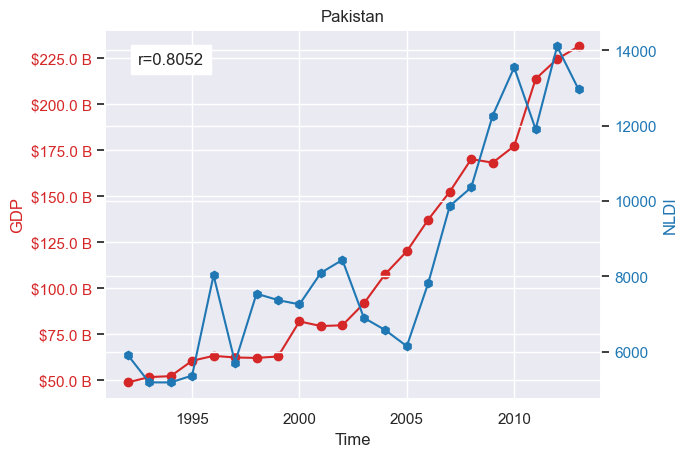

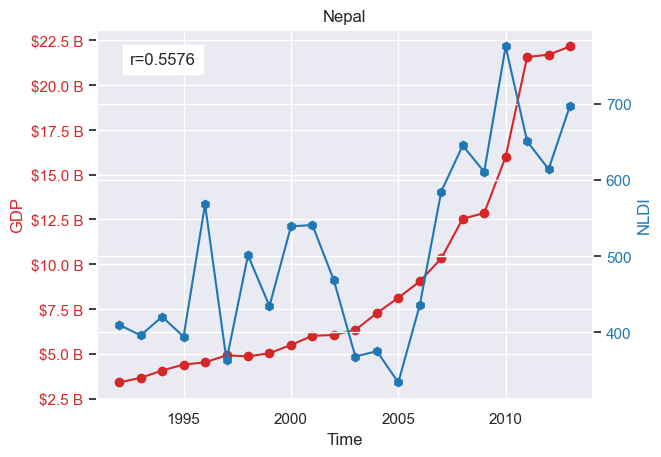

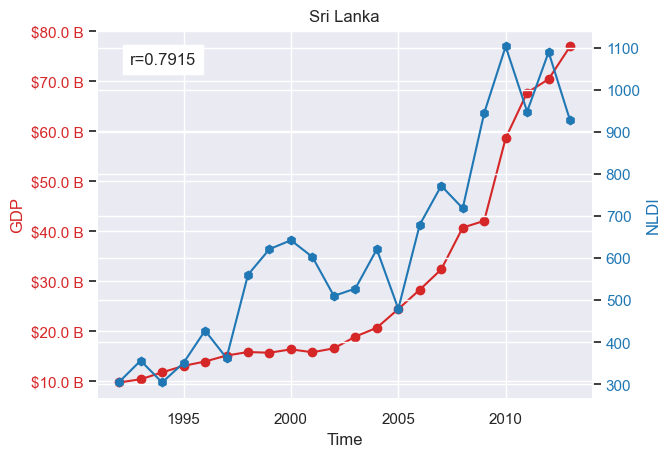

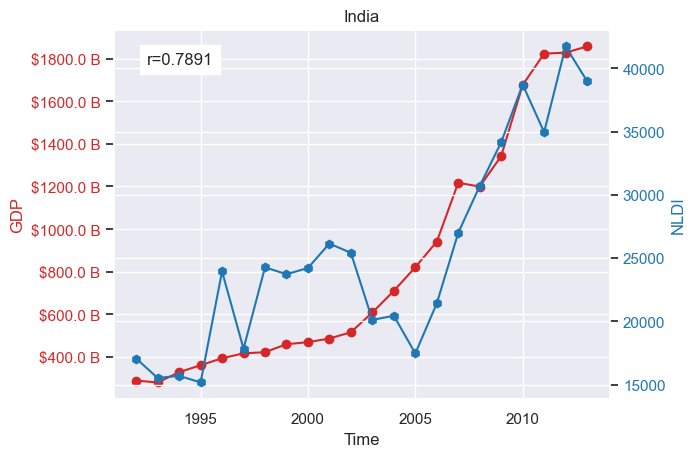

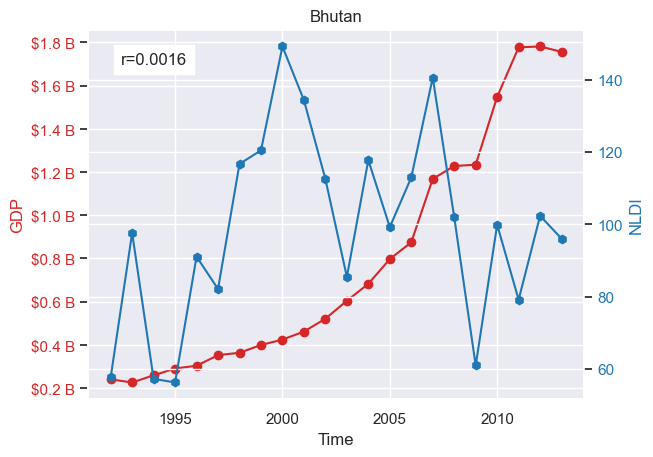

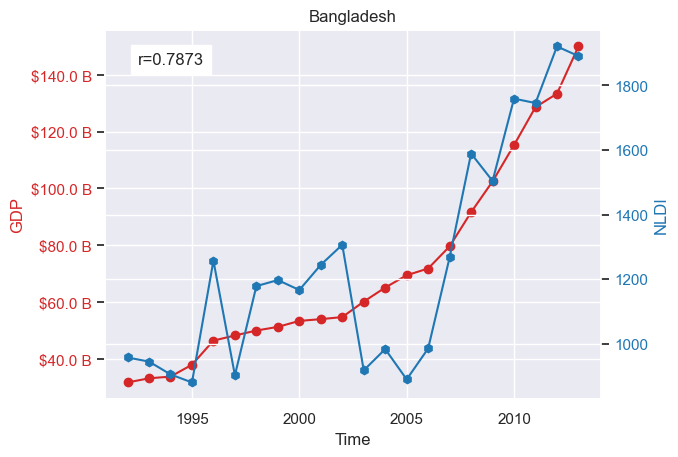

In [152]:
for country in countries_interested:
    cgdp = gdp.loc[country]
    cnl = nl.loc[country]
    
    # print(cnl.head())
    # print(cgdp.head())
    x = cnl.year.array
    y1 = cnl.loc[country].nlui.array
    y2 = cgdp.array[2:]

    plot_(y2, 'GDP', y1, 'NLDI', x, 'Time', country)

In [144]:
# Show all countries
d = {}
gdp = ps.read_csv(gdp_dataset_filtered, skiprows=0)
nl = ps.read_csv(nightlight, skiprows=0)
gdp = gdp.set_index('Name')
nl = nl.set_index('country')

for country in countries_interested:
    cgdp = gdp.loc[country]
    cnl = nl.loc[country]
     
    _years = cnl.year.array
    _cnldi = cnl.loc[country].nldi.array
    _cnlui = cnl.loc[country].nlui.array
    _cgdp = cgdp[2:]
    _country = ps.array([country for _ in range(len(_cnldi))])

    if len(d) == 0:
        d['year'] = _years
        d['country'] = _country
        d['nldi'] = _cnldi
        d['nlui'] = _cnlui
        d['gdp'] = _cgdp
    else:
        d['year'] = np.append(d['year'], _years)
        d['country'] = np.append(d['country'], _country)
        d['nldi'] = np.append(d['nldi'], _cnldi)
        d['nlui'] = np.append(d['nlui'], _cnlui)
        d['gdp'] = np.append(d['gdp'], _cgdp)
# print(len(d['country']), d['country'])
# print(len(d['nldi']), d['nldi'])
# print(len(d['nlui']), d['nlui'])
# print(len(d['gdp']), d['gdp'])

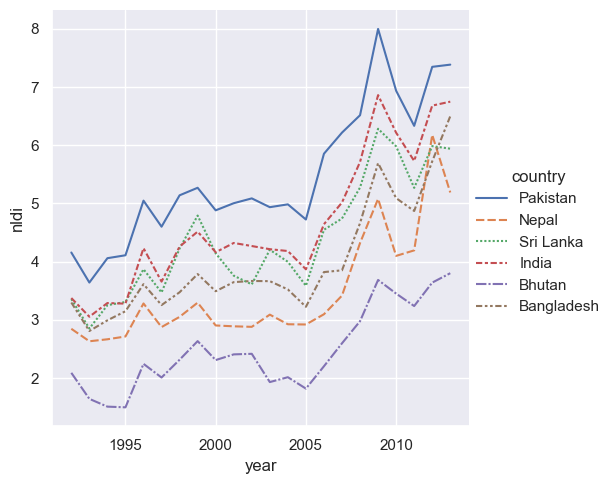

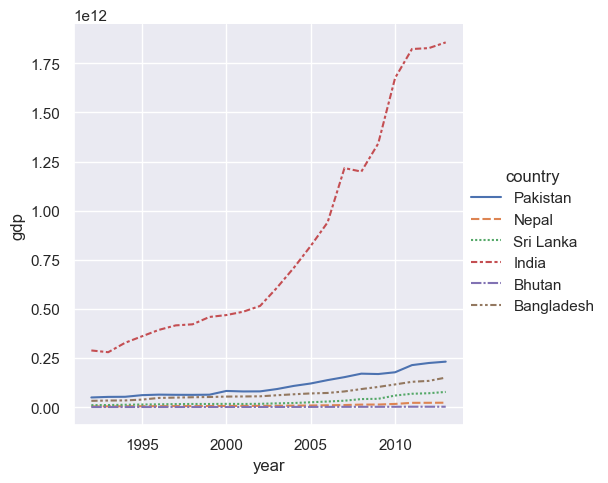

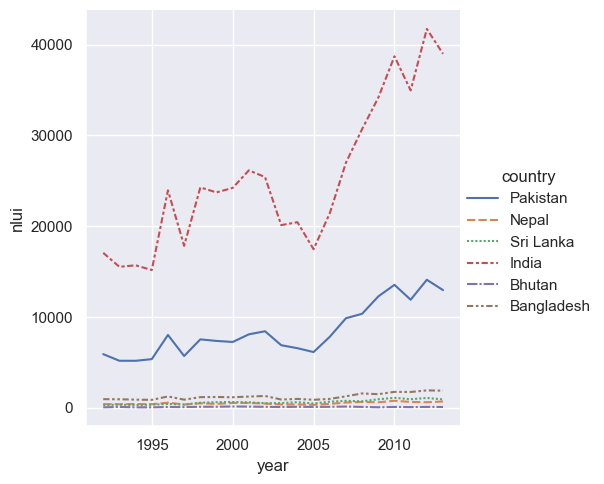

In [145]:
df = ps.DataFrame(d)
sns.set_theme()

plot1 = sns.relplot(x="year", y="nldi", hue='country', kind="line", style="country", height=5, legend='full', data=df)
# plot1.set(xlabel ="Time", ylabel = "Night Light Index", title ='Night Light Index/Time')

plot2 = sns.relplot(x="year", y="gdp", hue='country', kind="line", style="country", height=5, legend='full', data=df)
# plot2.set(xlabel ="Time", ylabel = "GDP", title ='GDP/Time')
# plot2.ax.yaxis.set_major_formatter(FuncFormatter(billions))

plot3 = sns.relplot(x="year", y="nlui", hue='country', kind="line", style="country", height=5, legend='full', data=df)

# sea.relplot(x="year", y="nl", hue='country', kind="scatter", style="country", col="country", height=5, data=df)
# sea.relplot(x="year", y="gdp", hue='country', kind="line", style="country", col="country", height=3, data=df)

# ['layer', 'stack', 'fill']
# ['hist', 'kde', 'ecdf']
# sea.displot(x="year", y="nl", col="country", kind="kde", height=5, data=df)

# sns.catplot(data=df, x="country", y="gdp", hue="country", kind="swarm")
# sns.catplot(data=df, x="country", y="nl", hue="country", kind="swarm")
# plt.text(.20,.94,"r={}".format(linear_regression(df.nl.array, df.gdp.array)), bbox={'facecolor':'w','pad':5}, ha="right", va="top", transform=plt.gca().transAxes) 
plt.show()

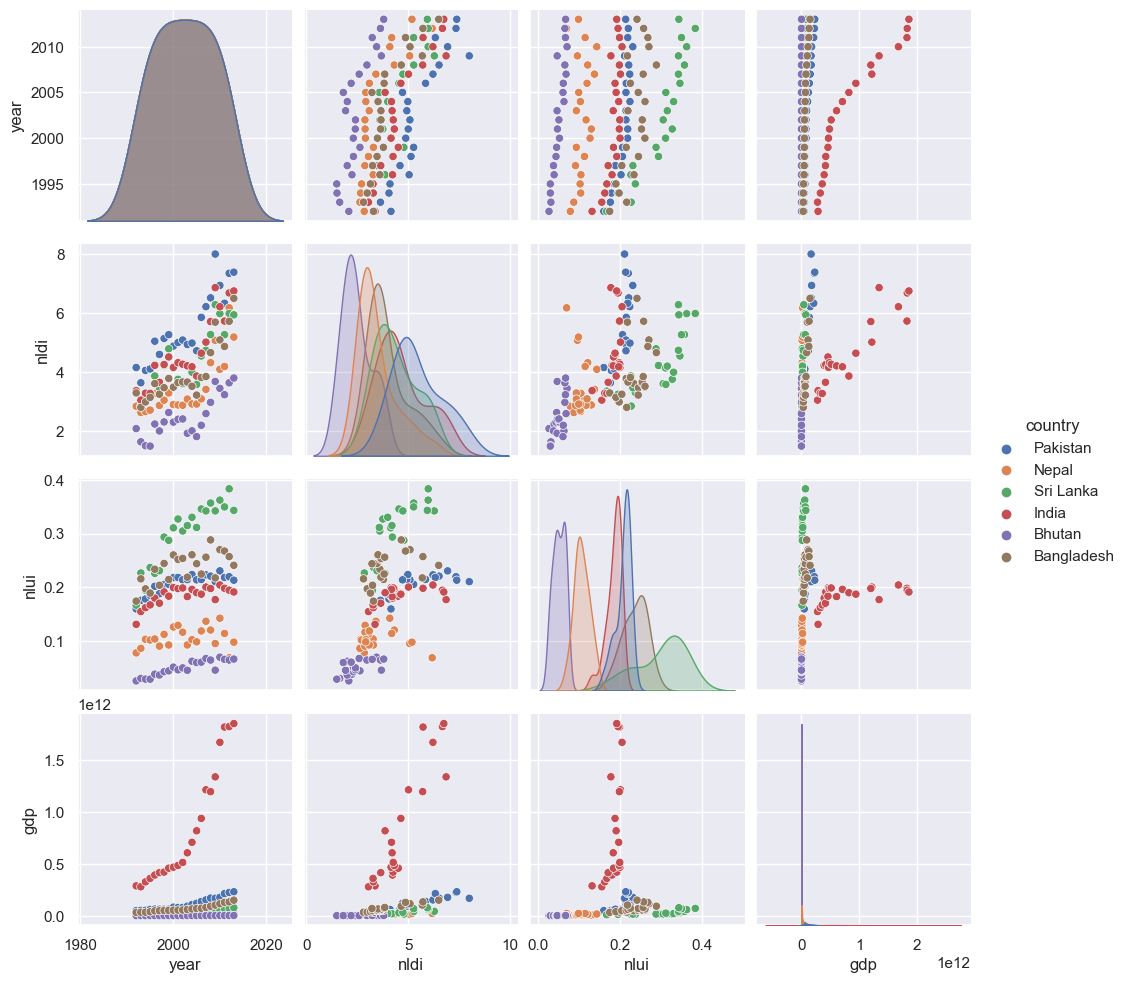

In [116]:
sns.pairplot(data=df, hue='country')
plt.show()

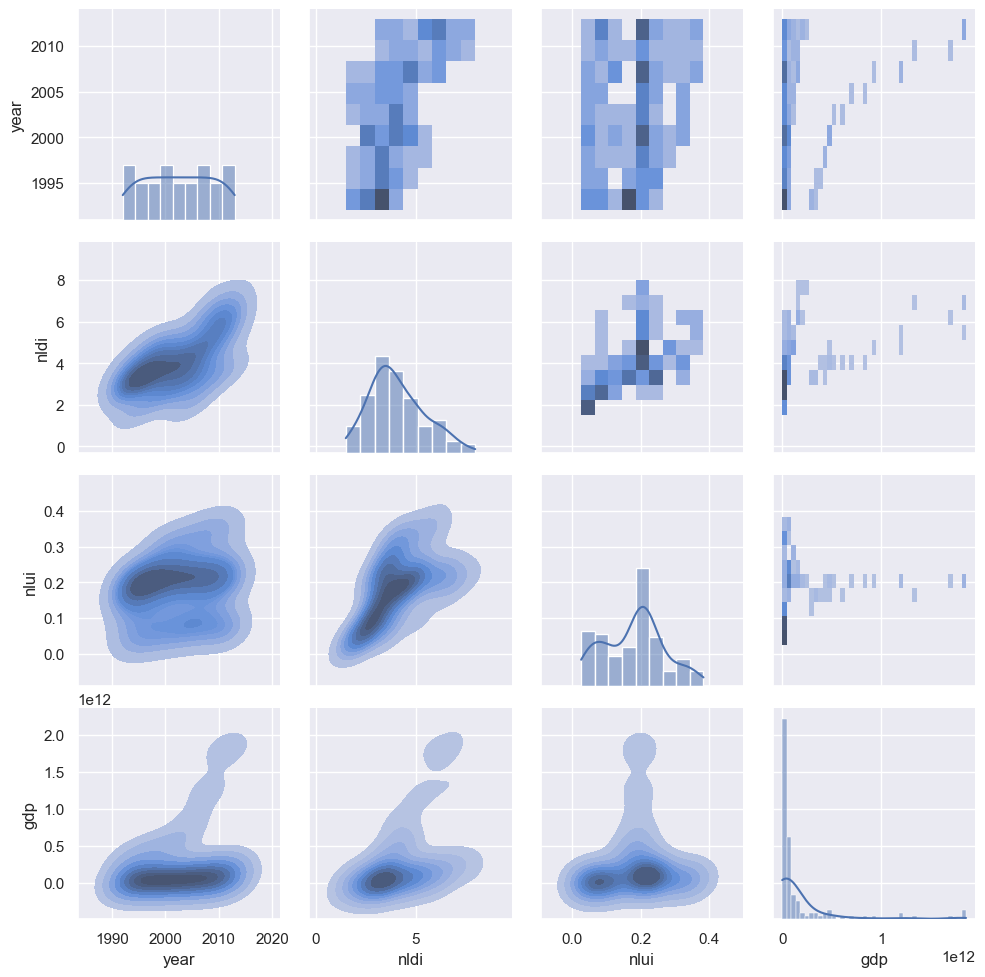

In [117]:
g = sns.PairGrid(df)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

In [20]:
# Split the data into training and testing sets

all_years = train_years = list(range(year_start, year_end+1))
train_years = list(range(year_start, (year_end - test_for_year)+1))
test_years = list(range((year_end - test_for_year) + 1, year_end+1))

tmp_array = []
for iso, data_list in nightlight_dataset.items():
    if iso == ISO:
        tmp_array = data_list[:-1*(test_for_year)]
        break
train_x = np.array(tmp_array) # training set x

tmp_array = []
for iso, gdp_ in gdp.items():
    if iso == ISO:
        tmp_array = gdp_[:-1*(test_for_year)]
        break
train_y = np.array(tmp_array) # training set y

tmp_array = []
for iso, data_list in nightlight_dataset.items():
    if iso == ISO:
        tmp_array = data_list[-1*(test_for_year):]
test_x = np.array(tmp_array) # test set x

tmp_array = []
for iso, gdp_ in gdp.items():
    if iso == ISO:
        tmp_array = gdp_[-1*(test_for_year):]
        break
test_y = np.array(tmp_array) # training set y

# train_xy = np.vstack((train_x, train_y)).T
# test_xy = np.vstack((test_x, test_y)).T


print("All Years:", len(all_years), [all_years[0], all_years[-1]])
print("Train Years:", len(train_years), [train_years[0], train_years[-1]])
print("Test Years:", len(test_years), [test_years[0], test_years[-1]])
print("--"*15)
print("NTL Train:", len(train_x), [train_x[0], train_x[-1]])
print("GDP Train:", len(train_y), [train_y[0], train_y[-1]])
print("--"*8)
print("NTL Test:", len(test_x), [test_x[0], test_x[-1]])
print("GDP Test:", len(test_y), [test_y[0], test_y[-1]])



NameError: name 'year_start' is not defined

In [40]:
import statsmodels.api as sm
import matplotlib.animation as animation
from sklearn import datasets, linear_model

# !pip install statsmodels


ModuleNotFoundError: No module named 'statsmodels'

Predicted: 3 [93826338880.74265, 141042864708.1956]
Actual: 3 [128637938711.386, 149990451022.29]
Mean Squared Error: 5.035279128926732e+20
R2 Score: -5.003108118733537


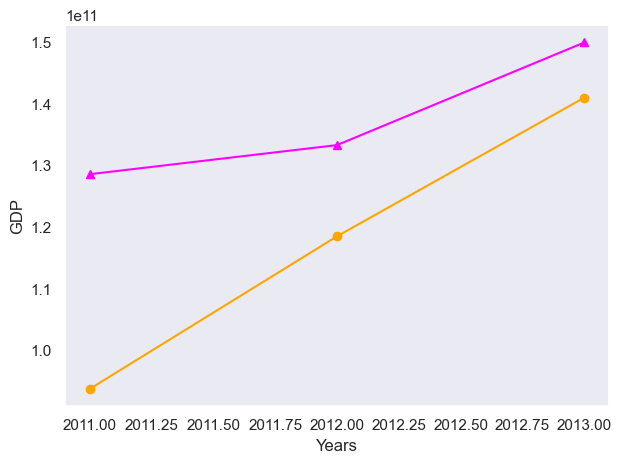

In [136]:
# Train the linear regression model on the training data
test_points = -3
range_start = 22*5
range_end = 22*6
train_x = df["nldi"].to_numpy()[range_start:range_end][:test_points]
train_y = df["gdp"].to_numpy()[range_start:range_end][:test_points]
test_x = df["nldi"].to_numpy()[range_start:range_end][test_points:]
test_y = df["gdp"].to_numpy()[range_start:range_end][test_points:]
all_y = df["gdp"].to_numpy()[range_start:range_end]

model = LinearRegression() #RandomForestRegressor
model2 = RandomForestRegressor()
model.fit(X=train_x.reshape(-1, 1), y=train_y)
model2.fit(X=train_x.reshape(-1, 1), y=train_y)

# Predict the GDP values for the test data
pred_y = model.predict(test_x.reshape(-1, 1)).ravel()
print("Predicted:", len(pred_y), [pred_y[0], pred_y[-1]])
print("Actual:", len(test_y), [test_y[0], test_y[-1]])

# Evaluate the performance of the model
mse = mean_squared_error(test_y, pred_y)
r2 = r2_score(test_y, pred_y)
print("Mean Squared Error:", mse)
print("R2 Score:", r2)


all_x = np.concatenate([train_x, test_x])
all_y = np.concatenate([train_y, test_y])

# Plot the results
fig, ax1 = plt.subplots()
ax1.set_xlabel('Years')
ax1.set_ylabel('GDP')
# ax1.plot(df["year"].to_numpy(), all_y, marker="s", color='red')
ax1.plot(df["year"].to_numpy()[test_points:], pred_y, marker="o", color='orange')
ax1.plot(df["year"].to_numpy()[test_points:], test_y, marker="^", color='magenta')
ax1.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.grid()
plt.show()


In [41]:
x = sm.add_constant(train_x).astype(float)

mod = sm.OLS(train_x, train_y)
res_v1= mod.fit()
print(res_v1.summary())


mod = sm.OLS(train_x, train_y)
mod = mod.fit()
x_1 = np.arange(2010,2014,1)
x_2 = np.arange(1992,2014,1)

%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
print(mod.predict(test_y).ravel())
ax.scatter(train_x, train_y, color='red', marker='h')
ax.plot(test_x, test_y, color='blue', marker='^')
ax.scatter(mod.predict(test_y).ravel(), test_y, c="orange")
ax.plot(mod.predict(test_y).ravel(), test_y, c="green")

NameError: name 'sm' is not defined

In [42]:
import tensorflow as tf


In [43]:
# Optionally, the first layer can receive an `input_shape` argument:
model = tf.keras.Sequential()
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(train_x, train_y, epochs=500)


NameError: name 'train_x' is not defined

In [44]:
print(predictions)
print(test_y)
print(test_x)

NameError: name 'predictions' is not defined

NameError: name 'train_years' is not defined

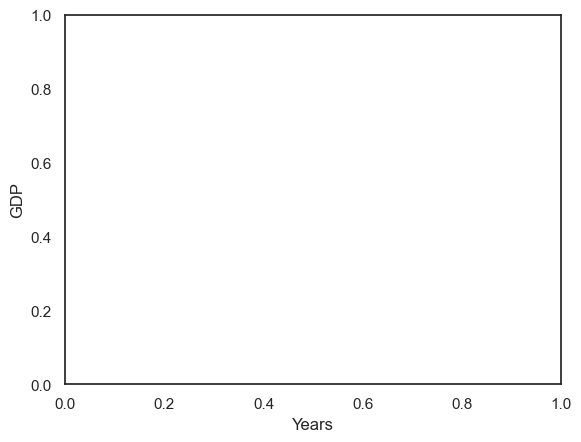

In [45]:
# Plot the results
fig, ax1 = plt.subplots()
ax1.set_xlabel('Years')
ax1.set_ylabel('GDP')
ax1.plot(train_years, train_y, marker="s", color='red')
ax1.plot(test_years, predictions, marker="o", color='orange')
ax1.plot(test_years, test_y, marker="^", color='magenta')
ax1.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.grid()
plt.show()